In [1]:
list.of.packages <- c("data.table",
"magrittr",
"ggplot2",
"lubridate",
"xts",
"forecast",
"DT",
"gridExtra",
"leaflet",
"htmltools",
"mapdata",
"maptools",
"sp")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [2]:
library(data.table)
library(magrittr)
library(ggplot2)
library(lubridate)
library(xts)
library(forecast)
library(DT)
library(gridExtra)
library(leaflet)
library(htmltools)
library(mapdata)
library(maptools)
library(sp)

theme_set(theme_bw())


Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:data.table’:

    first, last

Loading required package: maps
Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


In [3]:
visits <- fread('../input/air_visit_data.csv')
air_res <- fread('../input/air_reserve.csv')
hpg_res <- fread('../input/hpg_reserve.csv')
dates <- fread('../input/date_info.csv')
hpg_store <- fread('../input/hpg_store_info.csv')
air_store <- fread('../input/air_store_info.csv')
store_id_rel <- fread('../input/store_id_relation.csv')

Read 2000320 rows and 4 (of 4) columns from 0.118 GB file in 00:00:05


In [4]:
files <- list(visits, air_res, hpg_res, dates, hpg_store, air_store, store_id_rel)

data.frame(
    File = c('visits', 'air_res', 'hpg_res', 'dates', 'hpg_store', 'air_store', 'store_id_rel'),
    Nrows = sapply(files, nrow),
    Ncols = sapply(files, ncol),
    Size = sapply(files, function(x) { format(object.size(x), units = 'Mb')})
) %>%
    datatable(
        rownames = FALSE, 
        options = list(
            'paging' = FALSE, 
            'searching' = FALSE,
            columnDefs = list(list(width = '160px', className = 'dt-left', targets = '_all'))))

HTML widgets cannot be represented in plain text (need html)

In [5]:
summary(visits)

 air_store_id        visit_date           visitors     
 Length:252108      Length:252108      Min.   :  1.00  
 Class :character   Class :character   1st Qu.:  9.00  
 Mode  :character   Mode  :character   Median : 17.00  
                                       Mean   : 20.97  
                                       3rd Qu.: 29.00  
                                       Max.   :877.00  

In [6]:
visits[, .(total_visits = sum(visitors)), by = visit_date] %>%
    ggplot(aes(x = total_visits)) +
    geom_histogram(fill = 'steelblue') +
    labs(x = 'Daily visits', title = 'Distribution of daily visits')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


In [ ]:
visits[, visit_date := as.Date(visit_date)];

holidays <- dates[holiday_flg == 1, ];



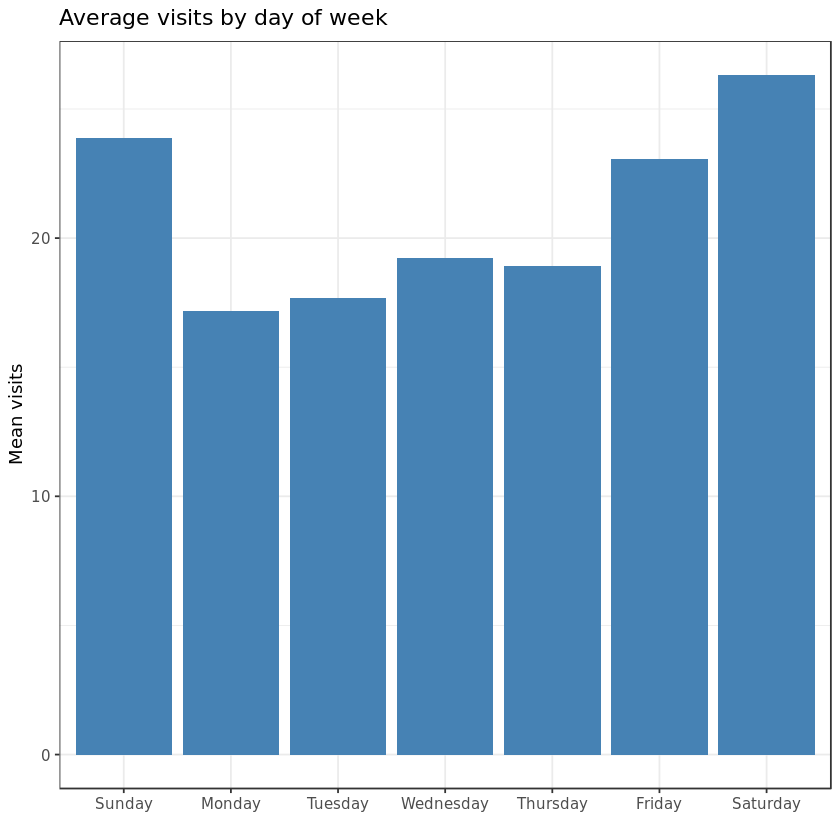

In [23]:
visits[order(wday(visit_date)), .(mean_visits = mean(visitors)), by = weekdays(visit_date)] %>%
    ggplot(aes(x = reorder(weekdays, seq(1,7)), y = mean_visits)) + 
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = "Mean visits", title = "Average visits by day of week")


In [24]:
 visits[, .(total_visitors = sum(visitors)), by = visit_date] %>% 
    as.xts() %>% 
    ggAcf() +
    labs(title = 'Autocorrelation plot of total visitors')


In [25]:
visits[, .(total_visitors = sum(visitors)), by = visit_date] %>% 
    as.xts() %>% 
    ggPacf() +
    labs(title = 'Partial Autocorrelation plot of total visitors')
    

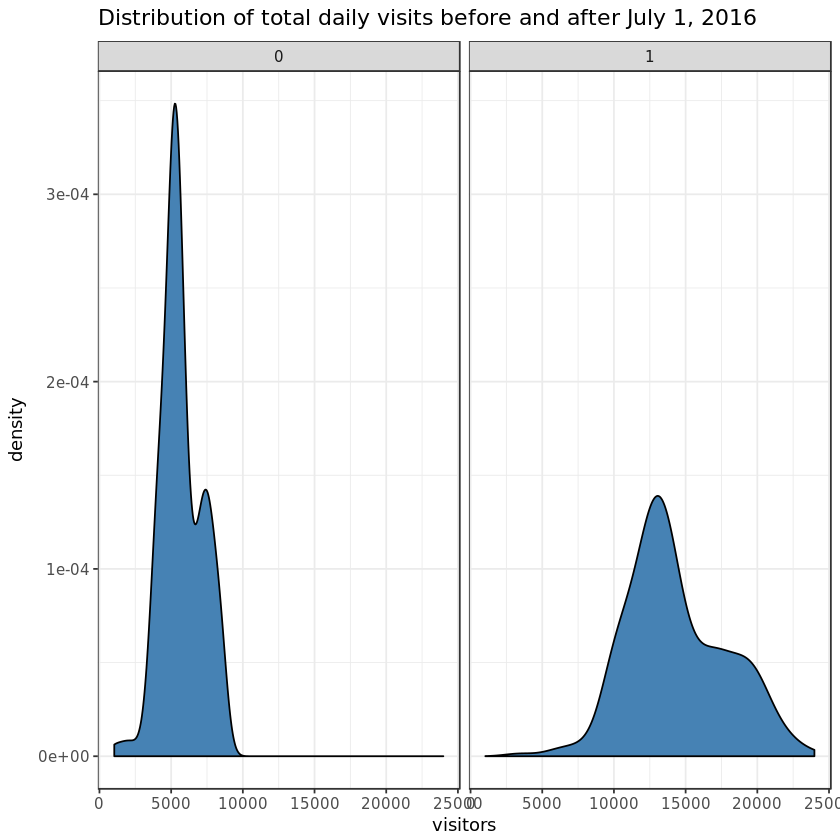

In [21]:
visits[, .(visitors = sum(visitors), s = ifelse(visit_date < as.Date('2016-07-01'), 0, 1)), by = visit_date] %>%
    ggplot(aes(x = visitors)) + 
    geom_density(fill = 'steelblue') +
    facet_grid(~s) + 
    labs(title = 'Distribution of total daily visits before and after July 1, 2016')

In [26]:
n_air <- length(unique(air_store$air_store_id))
n_hpg <- length(unique(hpg_store$hpg_store_id))

print(paste('The AirREGI data has', n_air, 'stores', 'and the Hot Pepper Gourmet data has', n_hpg, 'stores.'))

[1] "The AirREGI data has 829 stores and the Hot Pepper Gourmet data has 4690 stores."


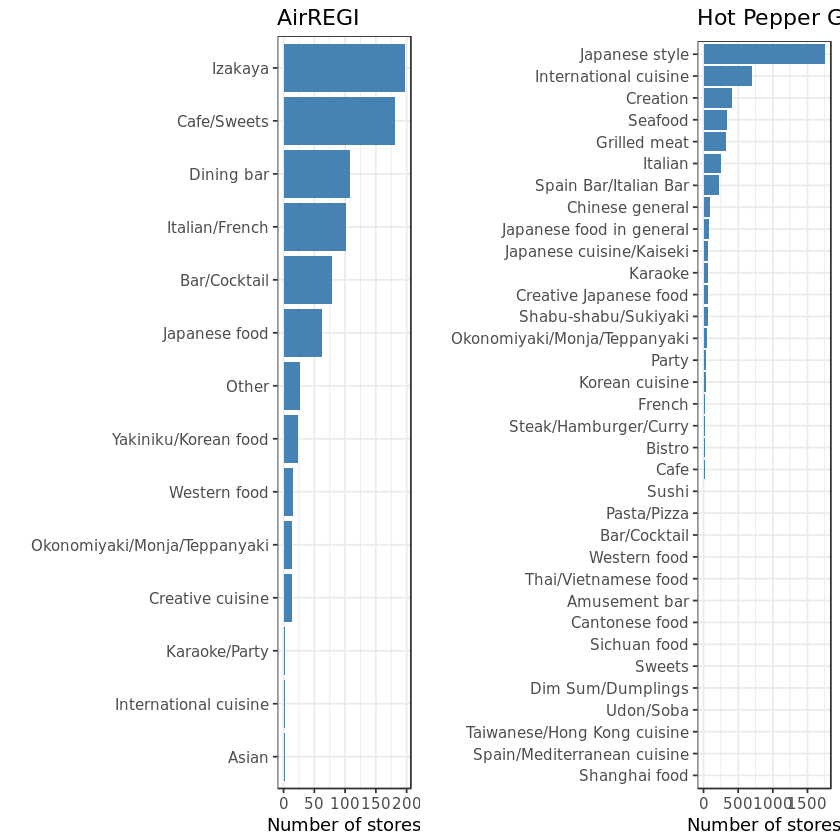

In [27]:
p1 <- air_store[, .N, by = air_genre_name] %>%
    ggplot(aes(x = reorder(air_genre_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'AirREGI') + 
    coord_flip()

p2 <- hpg_store[, .N, by = hpg_genre_name] %>%
    ggplot(aes(x = reorder(hpg_genre_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'Hot Pepper Gourmet') + 
    coord_flip()

grid.arrange(p1, p2, ncol = 2)

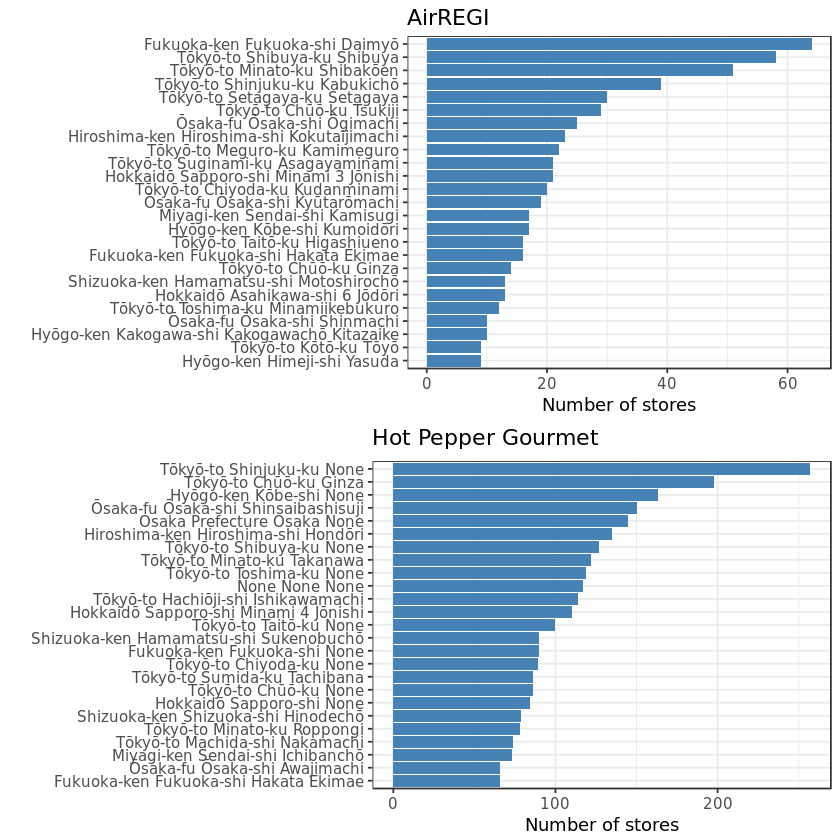

In [30]:
p1 <- air_store[, .N, by = air_area_name][order(N, decreasing = TRUE)] %>%
    head(25) %>%
    ggplot(aes(x = reorder(air_area_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'AirREGI') + 
    coord_flip()

p2 <- hpg_store[, .N, by = hpg_area_name][order(N, decreasing = TRUE)] %>%
    head(25) %>%
    ggplot(aes(x = reorder(hpg_area_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'Hot Pepper Gourmet') + 
    coord_flip()

grid.arrange(p1, p2, nrow = 2)

air_store_id         air_genre_name       
1   air_0f0cdeee6c9bf3d7 Italian/French       
2   air_7cc17a324ae5c7dc Italian/French       
3   air_fee8dcf4d619598e Italian/French       
4   air_a17f0778617c76e2 Italian/French       
5   air_83db5aff8f50478e Italian/French       
6   air_99c3eae84130c1cb Italian/French       
7   air_f183a514cb8ff4fa Italian/French       
8   air_6b9fa44a9cf504a1 Italian/French       
9   air_0919d54f0c9a24b8 Italian/French       
10  air_2c6c79d597e48096 Italian/French       
11  air_0164b9927d20bcc3 Italian/French       
12  air_681f96e6a6595f82 Italian/French       
13  air_ef920fa6f4b085f6 Italian/French       
14  air_d3e7b5952cd09ccb Italian/French       
15  air_e64de0a6bf0739af Italian/French       
16  air_4ce7b17062a1bf73 Italian/French       
17  air_290e7a57b390f78e Italian/French       
18  air_4579cb0669fd411b Italian/French       
19  air_63a750d8b4b6a976 Italian/French       
20  air_9438d67241c81314 Italian/French       
21  air_929d8513e3cdb423 Italian/French       
22  air_6c1128955c58b690 Italian/French       
23  air_638c35eb25e53eea Italian/French       
24  air_a7404a854919e990 Italian/French       
25  air_f6cdaf7b7fdc6d78 Italian/French       
26  air_df9355c47c5df9d3 Italian/French       
27  air_bf617aa68d5f1cfa Italian/French       
28  air_a218912784bf767d Italian/French       
29  air_506fe758114df773 Italian/French       
30  air_0b9038300f8b2b50 Italian/French       
⋮   ⋮                    ⋮                    
800 air_c7d30ab0e07f31d5 Other                
801 air_8a906e5801eac81c Other                
802 air_efef1e3daecce07e Other                
803 air_26f10355d9b4d82a Other                
804 air_4254c3fc3ad078bd Other                
805 air_82a6ae14151953ba Other                
806 air_24e8414b9b07decb Other                
807 air_5e339a1f364cdb00 Other                
808 air_d07e57b21109304a Western food         
809 air_2cee51fa6fdf6c0d Western food         
810 air_12c4fb7a423df20d Western food         
811 air_25d8e5cc57dd87d9 Western food         
812 air_57c9eea1a2b66e65 Western food         
813 air_0728814bd98f7367 Western food         
814 air_79f528087f49df06 Western food         
815 air_b45b8e456f53942a Western food         
816 air_0a74a5408a0b8642 Western food         
817 air_890d7e28e8eaaa11 Western food         
818 air_bedd35489e666605 Western food         
819 air_daa7947e1c47f5ed Western food         
820 air_e9ebf7fc520ac76a Western food         
821 air_f4936b91c9addbf0 Western food         
822 air_47beaffd3806c979 Western food         
823 air_edd5e3d696a5811b Western food         
824 air_6b65745d432fd77f International cuisine
825 air_9bf595ef095572fb International cuisine
826 air_764f71040a413d4d Asian                
827 air_10bbe8acd943d8f6 Asian                
828 air_7514d90009613cd6 Karaoke/Party        
829 air_c8fe396d6c46275d Karaoke/Party        
    air_area_name                         latitude longitude pref       
1   Hyōgo-ken Kōbe-shi Kumoidōri          34.69512 135.1979  Hyōgo-ken  
2   Hyōgo-ken Kōbe-shi Kumoidōri          34.69512 135.1979  Hyōgo-ken  
3   Hyōgo-ken Kōbe-shi Kumoidōri          34.69512 135.1979  Hyōgo-ken  
4   Hyōgo-ken Kōbe-shi Kumoidōri          34.69512 135.1979  Hyōgo-ken  
5   Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
6   Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
7   Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
8   Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
9   Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
10  Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
11  Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
12  Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
13  Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-to   
14  Tōkyō-to Minato-ku Shibakōen          35.65807 139.7516  Tōkyō-t

hpg_store_id         hpg_genre_name             
1    hpg_6622b62385aec8bf Japanese style             
2    hpg_e9e068dd49c5fa00 Japanese style             
3    hpg_2976f7acb4b3a3bc Japanese style             
4    hpg_e51a522e098f024c Japanese style             
5    hpg_e3d0e1519894f275 Japanese style             
6    hpg_530cd91db13b938e Japanese style             
7    hpg_02457b318e186fa4 Japanese style             
8    hpg_0cb3c2c490020a29 Japanese style             
9    hpg_3efe9b08c887fe9a Japanese style             
10   hpg_765e8d3ba261dc1c Japanese style             
11   hpg_46b3935373e2a576 Japanese style             
12   hpg_d02653e1cec8034d Japanese style             
13   hpg_ae7df991ba2f21ee Japanese style             
14   hpg_5f606bd0a074570e Japanese style             
15   hpg_c846b79f7170baf2 Japanese style             
16   hpg_6ab187222a3c9ea2 Japanese style             
17   hpg_8a67276f1608d544 Japanese style             
18   hpg_1a1c7f48b809e84b Japanese style             
19   hpg_b19c264d78431857 Japanese style             
20   hpg_f460793514dad711 Japanese style             
21   hpg_bcb6dd8efee30249 Japanese style             
22   hpg_9630a2129b625d89 Japanese style             
23   hpg_a7b8fbd9e2926703 Japanese style             
24   hpg_a7407b2899c77f4c Japanese style             
25   hpg_eb440c0d5a6df068 Japanese style             
26   hpg_a6a0ccb587ff39b0 Japanese style             
27   hpg_ff3a82aaa7e3c9b5 Japanese style             
28   hpg_5fee5882a0a44c43 Japanese style             
29   hpg_410a53a536b434c9 Japanese style             
30   hpg_e4641edebaf8eaec Japanese style             
⋮    ⋮                    ⋮                          
4661 hpg_9abed990fb16ce5d Western food               
4662 hpg_0fb2b561ddb41d98 Western food               
4663 hpg_2043905c504789be Western food               
4664 hpg_6606c638c06350a7 Western food               
4665 hpg_b73ea8282473c629 Western food               
4666 hpg_b94bd321ed2d3e87 Taiwanese/Hong Kong cuisine
4667 hpg_aeb7e5488dc0aa6f Cantonese food             
4668 hpg_5d5c7cf4a65a8928 Cantonese food             
4669 hpg_e52859e969de0bf9 Cantonese food             
4670 hpg_38502ff945160c3c Cantonese food             
4671 hpg_fae18d7ae5f8f2c1 Bar/Cocktail               
4672 hpg_00394a75a35c427c Bar/Cocktail               
4673 hpg_0ae8324ca1507b9b Bar/Cocktail               
4674 hpg_94f540568a79c2cb Bar/Cocktail               
4675 hpg_ba00993059032b30 Bar/Cocktail               
4676 hpg_126f14a1fba90056 Bar/Cocktail               
4677 hpg_79794b2252ab13ac Bar/Cocktail               
4678 hpg_9fe972ea62e642b2 Dim Sum/Dumplings          
4679 hpg_ac0bbe5ef3915656 Dim Sum/Dumplings          
4680 hpg_7a42d3e33ff1b54d Amusement bar              
4681 hpg_cde530deaa97c31c Amusement bar              
4682 hpg_a74709cf53c76924 Amusement bar              
4683 hpg_3c41f028563beac3 Amusement bar              
4684 hpg_e60322667e14b99c Amusement bar              
4685 hpg_68637e2b90172cd3 Sichuan food               
4686 hpg_c6ed353a48c7c93e Sichuan food               
4687 hpg_a58d2423360b2fb4 Sichuan food               
4688 hpg_d2021704076cdd70 Shanghai food              
4689 hpg_602472570d65e219 Spain/Mediterranean cuisine
4690 hpg_11801306ce8bfb4f Udon/Soba                  
     hpg_area_name                         latitude longitude pref      
1    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
2    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
3    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
4    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
5    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
6    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
7    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  
8    Tōkyō-to Setagaya-ku Taishidō         35.64367 139.6682  Tōkyō-to  


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


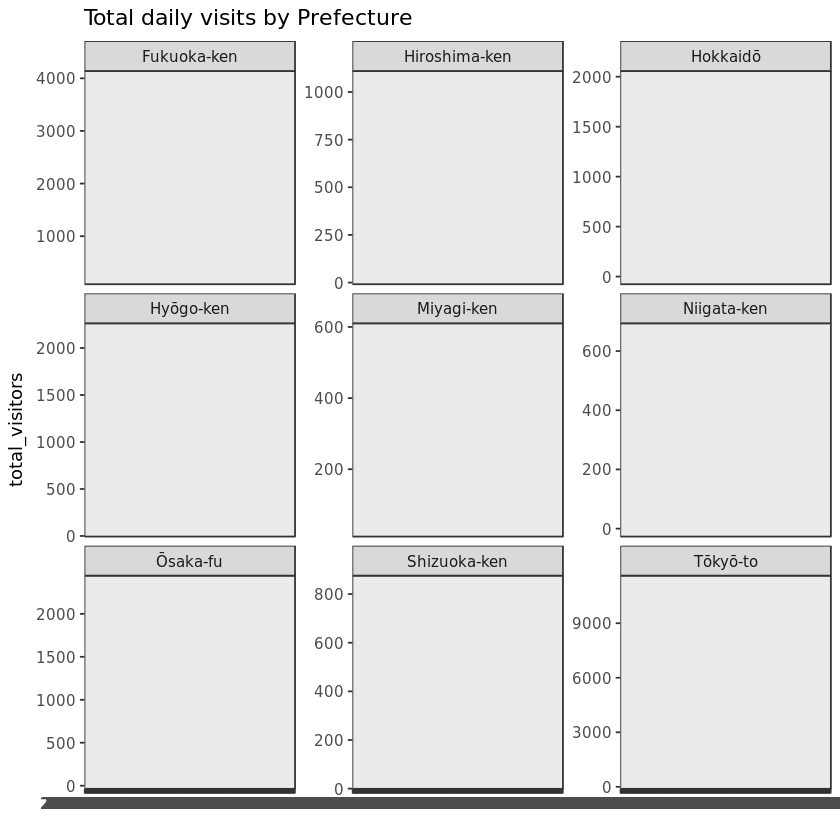

In [5]:
air_store[, pref := tstrsplit(air_area_name, split = " ", keep = 1)]
hpg_store[, pref := tstrsplit(hpg_area_name, split = " ", keep = 1)]

setkey(visits, air_store_id)
setkey(air_store, air_store_id)
setkey(hpg_store, hpg_store_id)



In [7]:
air_store

air_store_id         air_genre_name              
1   air_00a91d42b08b08d9 Italian/French              
2   air_0164b9927d20bcc3 Italian/French              
3   air_0241aa3964b7f861 Izakaya                     
4   air_0328696196e46f18 Dining bar                  
5   air_034a3d5b40d5b1b1 Cafe/Sweets                 
6   air_036d4f1ee7285390 Cafe/Sweets                 
7   air_0382c794b73b51ad Cafe/Sweets                 
8   air_03963426c9312048 Izakaya                     
9   air_04341b588bde96cd Izakaya                     
10  air_049f6d5b402a31b2 Japanese food               
11  air_04cae7c1bc9b2a0b Izakaya                     
12  air_0585011fa179bcce Dining bar                  
13  air_05c325d315cc17f5 Izakaya                     
14  air_0647f17b4dc041c8 Cafe/Sweets                 
15  air_064e203265ee5753 Cafe/Sweets                 
16  air_066f0221b8a4d533 Izakaya                     
17  air_06f95ac5c33aca10 Izakaya                     
18  air_0728814bd98f7367 Western food                
19  air_0768ab3910f7967f Dining bar                  
20  air_07b314d83059c4d2 Okonomiyaki/Monja/Teppanyaki
21  air_07bb665f9cdfbdfb Other                       
22  air_082908692355165e Italian/French              
23  air_083ddc520ea47e1e Cafe/Sweets                 
24  air_0845d8395f30c6bb Dining bar                  
25  air_084d98859256acf0 Izakaya                     
26  air_0867f7bebad6a649 Italian/French              
27  air_08ba8cd01b3ba010 Izakaya                     
28  air_08cb3c4ee6cd6a22 Izakaya                     
29  air_08ef81d5b7a0d13f Italian/French              
30  air_08f994758a1e76d4 Yakiniku/Korean food        
⋮   ⋮                    ⋮                           
800 air_f6b2489ccf873c3b Bar/Cocktail                
801 air_f6bfd27e2e174d16 Izakaya                     
802 air_f6cdaf7b7fdc6d78 Italian/French              
803 air_f8233ad00755c35c Italian/French              
804 air_f85e21e543cf44f2 Cafe/Sweets                 
805 air_f88898cd09f40496 Bar/Cocktail                
806 air_f911308e19d64236 Italian/French              
807 air_f9168b23fdfc1e52 Japanese food               
808 air_f927b2da69a82341 Okonomiyaki/Monja/Teppanyaki
809 air_f957c6d6467d4d90 Bar/Cocktail                
810 air_f96765e800907c77 Izakaya                     
811 air_fa12b40b02fecfd8 Italian/French              
812 air_fa4ffc9057812fa2 Dining bar                  
813 air_fab092c35776a9b1 Cafe/Sweets                 
814 air_fb44f566d4f64a4e Izakaya                     
815 air_fbadf737162a5ce3 Izakaya                     
816 air_fc477473134e9ae5 Bar/Cocktail                
817 air_fcd4492c83f1c6b9 Dining bar                  
818 air_fcfbdcf7b1f82c6e Italian/French              
819 air_fd154088b1de6fa7 Dining bar                  
820 air_fd6aac1043520e83 Izakaya                     
821 air_fdc02ec4a3d21ea4 Dining bar                  
822 air_fdcfef8bd859f650 Bar/Cocktail                
823 air_fe22ef5a9cbef123 Dining bar                  
824 air_fe58c074ec1445ea Cafe/Sweets                 
825 air_fea5dc9594450608 Other                       
826 air_fee8dcf4d619598e Italian/French              
827 air_fef9ccb3ba0da2f7 Japanese food               
828 air_ffcc2d5087e1b476 Izakaya                     
829 air_fff68b929994bfbd Bar/Cocktail                
    air_area_name                                latitude longitude
1   Tōkyō-to Chiyoda-ku Kudanminami              35.69400 139.7536 
2   Tōkyō-to Minato-ku Shibakōen                 35.65807 139.7516 
3   Tōkyō-to Taitō-ku Higashiueno                35.71261 139.7800 
4   Ōsaka-fu Ōsaka-shi Nakanochō                 34.70128 135.5281 
5   Ōsaka-fu Ōsaka-shi Ōhiraki                   34.69234 135.4722 
6   Hyōgo-ken Takarazuka-shi Tōyōchō             34.79977 135.3601 
7   Tōkyō-to Setagaya-ku Okusawa                 35.60213 139.6720 
8   Hiroshima-ken Hiroshima-shi Kokutaijimachi   34.38624 132.4550 
9   Tōkyō-to Nerima-ku Toyotamakita         

In [8]:
# create the labels
labels <- sprintf(
    "Store ID: %s</br>Prefecture:%s</br>Genre: %s", air_store$air_store_id, air_store$pref, air_store$air_genre_name) %>%
    lapply(HTML)




HTML widgets cannot be represented in plain text (need html)

In [9]:
air_store %>%
    leaflet() %>%
    addProviderTiles("CartoDB.Positron") %>%
    addCircleMarkers(~ longitude,
    ~ latitude,
    radius = 4,
    label = labels,
    clusterOptions = markerClusterOptions())

HTML widgets cannot be represented in plain text (need html)